<a href="https://colab.research.google.com/github/uncbiag/ICON/blob/master/notebooks/ICON_lung_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Registration of lung images using icon-registration
# http://github.com/uncbiag/ICON

In [ ]:
!git clone https://github.com/uncbiag/ICON
!pip install --quiet ./ICON

Cloning into 'ICON'...
remote: Enumerating objects: 1977, done.
remote: Counting objects: 100% (340/340), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 1977 (delta 182), reused 306 (delta 166), pack-reused 1637
Receiving objects: 100% (1977/1977), 139.83 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (1215/1215), done.
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 44 kB 2.7 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |█████████████

In [ ]:
import itk
import numpy as np
import unittest
import matplotlib.pyplot as plt
import numpy as np

import icon_registration.pretrained_models
import icon_registration.itk_wrapper
import icon_registration.test_utils


In [ ]:
## Fetch raw data

!girder-client --api-url https://data.kitware.com/api/v1 localsync 62a0efe5bddec9d0c4175c1f ./data

image_exp = itk.imread("data/copd1_highres_EXP_STD_COPD_img.nii.gz")
image_insp = itk.imread("data/copd1_highres_INSP_STD_COPD_img.nii.gz")
image_exp_seg = itk.imread("data/copd1_highres_EXP_STD_COPD_label.nii.gz")
image_insp_seg = itk.imread("data/copd1_highres_INSP_STD_COPD_label.nii.gz")
insp_points = icon_registration.test_utils.read_copd_pointset(
    "data/copd1_300_iBH_xyz_r1.txt"
)
exp_points = icon_registration.test_utils.read_copd_pointset(
    "data/copd1_300_eBH_xyz_r1.txt"
)

# images and segmentations are of type itk.Image with spatial metadata (origin, orientation, spacing)
# point sets are numpy arrays of points in physical coordinates

In [ ]:
## Fetch model

model = icon_registration.pretrained_models.LungCT_registration_model(
    pretrained=True
)

In [ ]:
## Preprocess images using provided function

## clip then scale intensity to [0, 1], mask out everything but lung

image_insp_preprocessed = (
    icon_registration.pretrained_models.lung_network_preprocess(
        image_insp, image_insp_seg
    )
)
image_exp_preprocessed = (
    icon_registration.pretrained_models.lung_network_preprocess(
        image_exp, image_exp_seg
    )
)

In [ ]:
# Perform registration on one pair
phi_AB, phi_BA = icon_registration.itk_wrapper.register_pair(
    model, image_insp_preprocessed, image_exp_preprocessed, finetune_steps=None
)

# itk_wrapper.register_pair uses the spatial metadata of its input images to produce 
# a transform that maps physical coordinates to physical coordinates

assert isinstance(phi_AB, itk.CompositeTransform)

In [ ]:
# Evaluate registration on one pair

# because image and deformation field spacing, orientation, etc are encapsulated by the library, 
# application code can work entirely in physical coordinates.

dists = []
for i in range(len(insp_points)):
    px, py = (
        exp_points[i],
        np.array(phi_BA.TransformPoint(tuple(insp_points[i]))),
    )
    dists.append(np.sqrt(np.sum((px - py) ** 2)))
print("Mean error on copd1: ", np.mean(dists))

dists = []
for i in range(len(insp_points)):
    px, py = (
        insp_points[i],
        np.array(phi_AB.TransformPoint(tuple(exp_points[i]))),
    )
    dists.append(np.sqrt(np.sum((px - py) ** 2)))
print("Mean error on copd1: ", np.mean(dists))


Mean error on copd1:  1.455589377099264
Mean error on copd1:  2.220936908921451


Checkerboard Before:


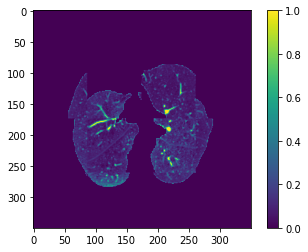

Difference image Before:


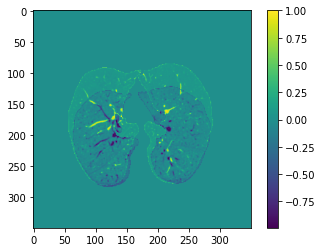

Checkerboard After:


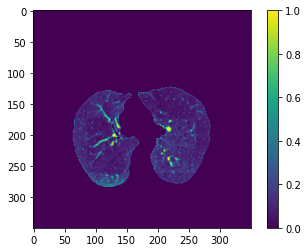

Difference image After:


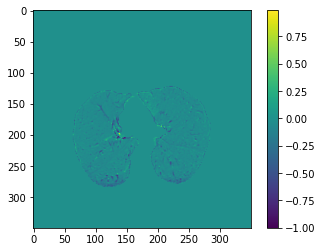

In [ ]:
# log some images to show the registration

interpolator = itk.LinearInterpolateImageFunction.New(image_insp_preprocessed)

warped_image_insp_preprocessed = itk.resample_image_filter(
    image_insp_preprocessed,
    transform=phi_AB,
    interpolator=interpolator,
    reference_image=image_exp_preprocessed,
    use_reference_image=True
)
print("Checkerboard Before:")
plt.imshow(
    np.array(
        itk.checker_board_image_filter(
            image_insp_preprocessed, image_exp_preprocessed
        )
    )[140]
)
plt.colorbar()
plt.show()
print("Difference image Before:")
plt.imshow(
    np.array(image_insp_preprocessed)[140]
    - np.array(image_exp_preprocessed)[140]
)
plt.colorbar()
plt.show()

print("Checkerboard After:")
plt.imshow(
    np.array(
        itk.checker_board_image_filter(
            warped_image_insp_preprocessed, image_exp_preprocessed
        )
    )[140]
)

plt.colorbar()
plt.show()
print("Difference image After:")
plt.imshow(
    np.array(warped_image_insp_preprocessed)[140]
    - np.array(image_exp_preprocessed)[140]
)
plt.colorbar()
plt.show()


In [ ]:
# Register again, but use fine tuning
# slower but more accurate
phi_AB, phi_BA = icon_registration.itk_wrapper.register_pair(
    model, image_insp_preprocessed, image_exp_preprocessed, finetune_steps=15
)

dists = []
for i in range(len(insp_points)):
    px, py = (
        exp_points[i],
        np.array(phi_BA.TransformPoint(tuple(insp_points[i]))),
    )
    dists.append(np.sqrt(np.sum((px - py) ** 2)))
print("Mean error on copd1: ", np.mean(dists))

dists = []
for i in range(len(insp_points)):
    px, py = (
        insp_points[i],
        np.array(phi_AB.TransformPoint(tuple(exp_points[i]))),
    )
    dists.append(np.sqrt(np.sum((px - py) ** 2)))
print("Mean error on copd1: ", np.mean(dists))


Mean error on copd1:  1.257938198025119
Mean error on copd1:  1.591798404834922


In [ ]:
# Get raw displacement field 
# Admittedly, this is a somewhat arcane incantation.

disp = itk.DisplacementFieldTransform[itk.D, 3].cast(phi_AB.GetNthTransform(1)).GetDisplacementField()

print(np.array(disp).shape)

# As an alternative, if you want to work with displacement fields
# you can skip the itk wrapper and use the raw network
# (no itk, only torch) as demoed here:
# https://github.com/uncbiag/ICON/blob/master/test/test_lung_registration.py
# at the price of having to manually manage image origins, orientations, spacing, 
# and resampling inputs to the network's internal resolution

(175, 175, 175, 3)


In [ ]:
# Write transform to disk

itk.transformwrite([phi_AB], "phi_AB.hdf5")

In [ ]:
# Read transform from disk

itk.transformread("phi_AB.hdf5")[0]

<itk.itkCompositeTransformPython.itkCompositeTransformD3; proxy of <Swig Object of type 'itkCompositeTransformD3 *' at 0x7f3da92711b0> >

In [ ]:
# Convert transform to SimpleITK
!pip install SimpleITK
import SimpleITK as sitk
phi_AB_sitk = sitk.ReadTransform("phi_AB.hdf5")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.8 MB/s 


In [ ]:
# Computing determinants is easy in SITK
# Working on getting this filter into regular python itk

filt = sitk.TransformToDisplacementFieldFilter()
filt.SetReferenceImage(sitk.ReadImage("data/copd1_highres_EXP_STD_COPD_label.nii.gz"))
displacement_image_sitk = filt.Execute(phi_AB_sitk)
det_sitk = sitk.DisplacementFieldJacobianDeterminantFilter().Execute(displacement_image_sitk)

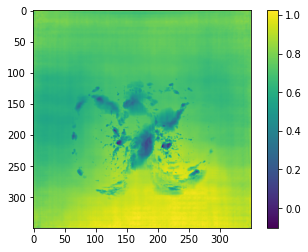

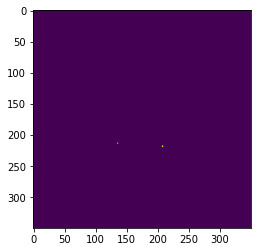

In [ ]:
# visualize the determinant
det = sitk.GetArrayFromImage(det_sitk)
plt.imshow(np.min(det, axis=0))
plt.colorbar()
plt.show()
plt.imshow(np.min(det, axis=0) < 0)
